In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import sys
sys.path.append('../keras_network/')
sys.path.append('../data_processing/')
from data_generator import DataGenerator
from losses import metrics, all_metrics
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in all_metrics])
get_custom_objects().update(metrics_dict)

/home1/05488/tg847872/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
aquafn = '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc'

In [3]:
ds = nc.Dataset(aquafn)

In [4]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.0
    source: CAM
    case: AndKua_aqua_SPCAM3.0_enhance05
    title: 
    logname: tg847872
    host: 
    Version: $Name:  $
    revision_Id: $Id: history.F90,v 1.26.2.38 2003/12/15 18:52:35 hender Exp $
    dimensions(sizes): lat(64), lon(128), lev(30), ilev(31), isccp_prs(7), isccp_tau(7), isccp_prstau(49), time(4), tbnd(2), chars(8), crm_x(8), crm_y(1), crm_z(28)
    variables(dimensions): float64 P0(), float64 lat(lat), float64 lon(lon), float64 crm_x(crm_x), float64 crm_y(crm_y), float64 crm_z(crm_z), float64 lev(lev), float64 ilev(ilev), float64 isccp_prs(isccp_prs), float64 isccp_tau(isccp_ta), float64 isccp_prstau(isccp_prsta), float64 time(time), float64 time_bnds(time,tbnd), |S1 date_written(time,chars), |S1 time_written(time,chars), int32 ntrm(), int32 ntrn(), int32 ntrk(), int32 ndbase(), int32 nsbase(), int32 nbdate(), int32 nbsec(), int32 mdt(), int32 n

In [5]:
mean = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/means.txt',
    delimiter=','
)

In [6]:
mean.shape

(152,)

In [7]:
std = np.loadtxt(
    '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/keras_matrices/stds.txt',
    delimiter=','
)

In [8]:
inps = ['TC', 'QC', 'VC', 'dTdt_adiab', 'dQdt_adiab', 'PS', 'SOLIN']
outps = ['SPDQ', 'SPDT', 'QRL', 'QRS']

In [9]:
dt = 1800.
t = 3

In [10]:
TC = ds['TAP'][t-1] - ds['DTV'][t-1] * dt
QC = ds['QAP'][t-1] - ds['VD01'][t-1] * dt
VC = ds['VAP'][t-1]

In [11]:
TC.shape

(30, 64, 128)

In [12]:
TBP = ds['TAP'][t] - ds['TPHYSTND'][t] * dt
QBP = ds['QAP'][t] - ds['PHQ'][t] * dt

In [13]:
dTdt_adiab = (TBP - TC) / dt
dQdt_adiab = (QBP - QC) / dt

In [14]:
PS = ds['NNPS'][t]
SOLIN = ds['NNSOLIN'][t]

In [15]:
PS = np.expand_dims(PS, 0); PS.shape

(1, 64, 128)

In [16]:
SOLIN = np.expand_dims(SOLIN, 0)

In [17]:
inp_arr_raw = np.concatenate([TC, QC, VC, dTdt_adiab, dQdt_adiab, PS, SOLIN]); inp_arr_raw.shape

(152, 64, 128)

In [18]:
def normalize(x):
    return (x - mean[:, None, None]) / std[:, None, None]

In [19]:
inp_arr_cb = np.concatenate(
    [ds['NNTC'][t], ds['NNQC'][t], ds['NNVC'][t], ds['dTdtadia'][t], ds['dQdtadia'][t],
     np.expand_dims(ds['NNPS'][t], 0), np.expand_dims(ds['NNSOLIN'][t], 0)]
); inp_arr_cb.shape

(152, 64, 128)

In [20]:
np.allclose(inp_arr_cb, inp_arr_raw)

False

In [21]:
inp_raw_norm = normalize(inp_arr_raw)
inp_cb_norm = normalize(inp_arr_cb)

In [53]:
def get_cb_inps(t, norm=True):
    x = np.concatenate(
        [ds['NNTC'][t], ds['NNQC'][t], ds['NNVC'][t], ds['dTdtadia'][t], ds['dQdtadia'][t],
         np.expand_dims(ds['NNPS'][t], 0), np.expand_dims(ds['NNSOLIN'][t], 0)]
    )
    return normalize(x) if norm else x

In [22]:
ilat = 33; ilon = 0

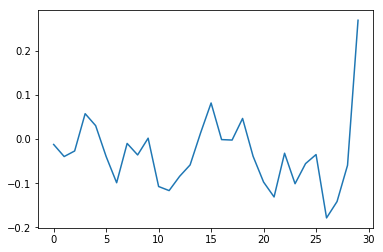

In [23]:
plt.plot(ds['BRAINDT'][3,:,ilat,ilon])

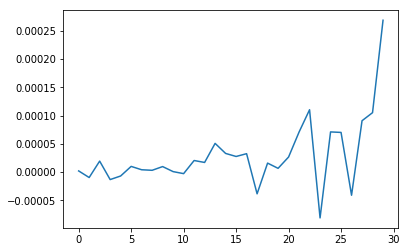

In [24]:
plt.plot(ds['BRAINDQ'][3,:,ilat,ilon])

## Get predictions

In [25]:
L_V = 2.5e6   # Latent heat of vaporization is actually 2.26e6
C_P = 1e3   # Specific heat capacity of air at constant pressure

In [26]:
m = keras.models.load_model('/home1/05488/tg847872/tmp/B001_purecrm_ess_sample1_base.h5')

In [27]:
inp_cb_norm.shape

(152, 64, 128)

In [28]:
preds = m.predict(inp_cb_norm.reshape(152, -1).T); preds.shape

(8192, 120)

In [29]:
preds = preds.T.reshape(120, 64, 128)

In [73]:
def get_cb_preds(t):
    cb_preds = np.concatenate(
        [ds['BRAINDQ'][t] * L_V, ds['BRAINDT'][t]* C_P, ds['QRL'][t] * C_P, ds['QRS'][t] * C_P]
    )
    return cb_preds

In [30]:
cb_preds = np.concatenate(
    [ds['BRAINDQ'][t] * L_V, ds['BRAINDT'][t]* C_P, ds['QRL'][t] * C_P, ds['QRS'][t] * C_P]
); cb_preds.shape

(120, 64, 128)

In [31]:
# BRAINDQ = ptend%q = SPDQ(output)
# SPDQ(output) = NNoutput / LV
# BRAINDT = (ptend%S = SPDT(output)) / CP
# SPDT(output) = NNoutput

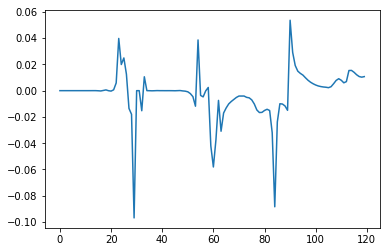

In [34]:
plt.plot(cb_preds[:, 0, 0])

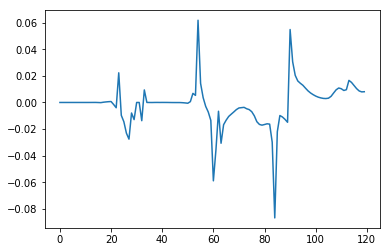

In [35]:
plt.plot(preds[:, 0, 0])

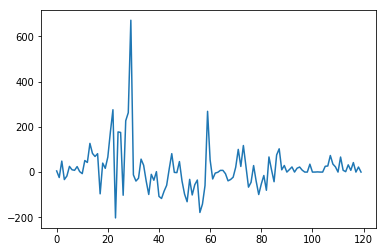

In [37]:
plt.plot(cb_preds[:, 33, 0]-preds[:, 33, 0])

In [200]:
ds['BRAINDQ']

<class 'netCDF4._netCDF4.Variable'>
float32 BRAINDQ(time, lev, lat, lon)
    units: kg/kg/s
    long_name: Q tendency - neural net for moist convection
    cell_method: time: mean
unlimited dimensions: time
current shape = (4, 30, 64, 128)
filling off

## Reproduce F90 vectors

In [38]:
search_val = 246.518145771772

In [59]:
inps_t1_raw = get_cb_inps(1, False)

In [60]:
a = np.abs(inps_t1_raw - search_val); a.shape

(152, 64, 128)

In [61]:
np.unravel_index(a.argmin(), a.shape)

(0, 0, 0)

In [62]:
inps_t1_raw[:, 0, 0]

array([ 2.4651814e+02,  2.3189018e+02,  2.1640247e+02,  2.3891216e+02,
        2.3194446e+02,  2.2959180e+02,  2.2944063e+02,  2.2874290e+02,
        2.2771008e+02,  2.2672400e+02,  2.2561212e+02,  2.2314035e+02,
        2.2125610e+02,  2.1830640e+02,  2.1714983e+02,  2.1836169e+02,
        2.2343808e+02,  2.3032021e+02,  2.3893547e+02,  2.4766966e+02,
        2.5389316e+02,  2.5808481e+02,  2.6173392e+02,  2.6425168e+02,
        2.6555685e+02,  2.6738092e+02,  2.6912375e+02,  2.7075772e+02,
        2.7226547e+02,  2.7362326e+02,  1.9037142e-06,  1.8891703e-06,
        1.7588474e-06,  1.7571419e-06,  1.7425954e-06,  1.6574567e-06,
        1.5940446e-06,  1.5920792e-06,  1.5923852e-06,  1.5992169e-06,
        1.6423849e-06,  1.7181877e-06,  2.1865117e-06,  4.1795220e-06,
        7.7228233e-06,  1.6083559e-05,  3.4336816e-05,  7.8597659e-05,
        2.4581162e-04,  5.1884243e-04,  8.2231179e-04,  1.1295289e-03,
        1.4988487e-03,  1.9153649e-03,  2.2750068e-03,  2.4801614e-03,
      

In [63]:
inps_t1_norm = get_cb_inps(1, True)

In [64]:
inps_t1_norm[:, 0, 0]

array([ 8.94153581e-01,  7.07858112e-01,  8.94260659e-01,  1.08749873e+00,
        1.11231759e+00,  1.37628314e+00,  1.47046584e+00,  1.49369949e+00,
        1.60869529e+00,  1.74392010e+00,  1.85987739e+00,  1.63947883e+00,
        9.41156410e-01,  8.47009521e-02, -4.86854805e-01, -8.53299017e-01,
       -9.91211354e-01, -1.06967220e+00, -1.06674921e+00, -1.00083740e+00,
       -1.00658204e+00, -1.05974458e+00, -1.03671283e+00, -1.00560546e+00,
       -1.04085340e+00, -1.02425766e+00, -1.00652098e+00, -9.87644488e-01,
       -9.60186400e-01, -9.49304483e-01,  1.59571251e+00,  1.72462031e+00,
        1.63699311e+00,  2.29418472e+00,  2.39237293e+00,  1.91740094e+00,
        1.25203412e+00,  7.47027224e-01,  2.60289519e-01, -4.04909216e-01,
       -6.05848793e-01, -6.36221750e-01, -6.11097726e-01, -5.71069410e-01,
       -5.49099813e-01, -5.38849585e-01, -5.49967062e-01, -5.67327831e-01,
       -5.37167798e-01, -5.36287141e-01, -6.03172823e-01, -7.41146176e-01,
       -8.52737668e-01, -

In [65]:
w = m.get_weights()

In [68]:
len(w), w[0].shape

(4, (152, 512))

In [69]:
w[0]

array([[ 0.08302586,  0.02850876,  0.07611392, ..., -0.04379965,
         0.04357586,  0.09792221],
       [ 0.03718822, -0.03001069,  0.05664457, ...,  0.05236302,
        -0.00342062,  0.0172641 ],
       [ 0.04920626,  0.03305241,  0.04127048, ..., -0.00547866,
         0.03435544,  0.03742914],
       ...,
       [ 0.02212742,  0.00229083,  0.00602679, ...,  0.03932348,
         0.04095541,  0.03244013],
       [ 0.04493503,  0.01651884,  0.06989796, ...,  0.07412373,
         0.06511395,  0.05881803],
       [ 0.02896229,  0.00742906,  0.03047865, ...,  0.02422526,
         0.04262394,  0.03720357]], dtype=float32)

In [70]:
w[1].shape, w[1]

((512,), array([-1.1471430e+00, -5.5024886e-01, -1.1187141e+00, -1.0000501e+00,
        -9.2298836e-01, -5.2432668e-01, -1.0362192e+00, -8.8687325e-01,
        -6.7875791e-01, -4.8341510e-01, -5.8572590e-01, -4.2292014e-01,
        -7.8629118e-01, -1.2535613e+00, -1.3290343e+00, -1.1482188e+00,
        -1.0495677e+00, -1.0344750e+00, -6.9547325e-01, -1.0325340e+00,
        -7.6395911e-01, -3.2090357e-01, -6.4444876e-01, -1.4616275e+00,
        -6.2317288e-01, -1.6601218e+00, -1.5379955e+00, -1.4365224e+00,
        -1.0982261e-01, -8.6402774e-01, -1.2945702e+00, -7.6952565e-01,
        -1.4660624e+00, -7.2162646e-01, -9.0254538e-02, -5.6250501e-01,
        -9.8670363e-01, -7.8801602e-01, -1.1954867e+00, -1.4470487e+00,
        -8.4946030e-01, -7.9670990e-01, -1.1868185e+00, -2.6673400e-01,
        -9.6592748e-01, -1.0565318e+00, -1.3555053e+00,  1.6901091e-01,
        -1.4503740e+00, -8.1493509e-01, -8.6205804e-01, -4.3011779e-01,
        -9.9840939e-01, -5.4980928e-01,  1.2573078e-01, 

In [71]:
w[2].shape, w[2]

((512, 120), array([[-1.1506757e-02, -1.5897522e-02,  1.0807238e-02, ...,
          2.1866947e-02,  2.5861107e-03,  4.6310346e-03],
        [ 1.3383994e-02,  4.4410606e-04, -8.8311435e-04, ...,
          7.1648080e-03,  1.8228015e-02,  2.1151697e-02],
        [ 6.1708386e-05,  1.8749708e-04,  2.4077271e-03, ...,
          1.0813772e-03,  8.3399948e-04,  7.3118584e-04],
        ...,
        [ 2.7155271e-04,  2.0407289e-03, -3.4579621e-03, ...,
          5.0071334e-03,  1.7461311e-02,  6.8856049e-03],
        [-8.8188509e-03,  2.2276124e-02,  1.0655303e-02, ...,
         -7.2789607e-03,  1.1731849e-02,  1.5030507e-03],
        [ 1.8692252e-03, -5.9006731e-03,  3.7077924e-03, ...,
         -2.1664819e-03,  6.5882009e-04, -6.3299120e-04]], dtype=float32))

In [72]:
w[3].shape, w[3]

((120,),
 array([ 9.23451537e-10, -4.88170926e-09, -1.08493701e-07,  2.23258908e-07,
        -2.08853326e-08, -5.86246607e-08,  2.40281972e-09,  8.67182877e-08,
        -3.42620638e-07, -3.45616650e-06, -6.49195408e-06,  8.29653982e-06,
         3.01487980e-05,  4.42991259e-05,  7.26969392e-06,  1.52656810e-07,
        -1.31305278e-04, -8.14954168e-04, -4.20534634e-04,  8.64264439e-04,
         6.74984418e-04,  2.04197969e-03,  4.31651529e-03,  3.57585982e-03,
        -1.10731693e-04, -1.89330280e-02, -2.37594154e-02, -1.56500768e-02,
        -1.03248842e-02, -1.03796497e-01, -4.32131619e-09, -3.81306764e-09,
        -1.08363293e-02,  7.68349553e-03, -1.07222158e-05, -2.02169449e-05,
        -1.22003854e-04, -3.82372469e-04, -2.31949634e-05, -9.07969952e-05,
        -1.78809569e-04,  1.67629387e-05,  3.06585949e-04,  3.00719985e-04,
         1.72877462e-05, -1.54234818e-04, -1.02682250e-04,  9.36399229e-05,
        -6.85678169e-05, -2.62314192e-04, -3.03050969e-04, -3.06119880e-04,
   

In [74]:
cb_preds = get_cb_preds(1); cb_preds.shape

(120, 64, 128)

In [75]:
cb_preds[:, 0, 0]

array([ 2.34397973e-10, -2.51775116e-08, -7.72114177e-08,  4.04922034e-08,
        2.67947424e-08, -1.13796705e-08, -2.37550015e-08,  5.84010849e-08,
       -2.89225355e-08, -1.56689083e-07, -3.06486754e-07,  4.40065264e-07,
        3.56251712e-06,  1.77912043e-05,  1.60059008e-05, -7.66918020e-05,
       -1.52114531e-04,  2.42216920e-04,  4.10808570e-04, -1.08690270e-04,
       -3.21631931e-04, -5.94295212e-04,  2.09452258e-03,  3.33547071e-02,
        1.33079449e-02,  1.31383315e-02,  4.47756611e-03, -7.41702691e-03,
       -3.19707696e-03, -8.49699676e-02, -2.70473812e-08,  6.58293864e-09,
       -1.53582133e-02,  1.06202839e-02,  8.75796104e-06, -2.93530338e-05,
       -1.22541387e-04, -6.47998240e-05,  4.68603139e-05,  9.56933945e-07,
        3.90997502e-06, -5.81222230e-06, -1.69980649e-06, -2.77110257e-06,
       -1.94401619e-05, -3.55489065e-05, -4.87485113e-06,  2.58288837e-05,
       -9.16494537e-05, -1.33476424e-04, -2.42010967e-04, -5.47044736e-04,
       -1.41649216e-03, -

In [94]:
def get_keras_preds(inp):
    return np.rollaxis(
        m.predict(np.rollaxis(inp.reshape(152, -1), 0, 2)).reshape(64, 128, 120), 2, 0
    )

In [95]:
k_preds = get_keras_preds(inps_t1_norm); k_preds.shape

(120, 64, 128)

In [96]:
k_preds[:, 0, 0]

array([ 2.34362640e-10, -2.51774868e-08, -7.72112259e-08,  4.04912868e-08,
        2.67946998e-08, -1.13799850e-08, -2.37547528e-08,  5.84014650e-08,
       -2.89222157e-08, -1.56691158e-07, -3.06491529e-07,  4.40031727e-07,
        3.56246528e-06,  1.77912007e-05,  1.60056152e-05, -7.66920784e-05,
       -1.52115259e-04,  2.42212787e-04,  4.10804292e-04, -1.08691456e-04,
       -3.21631436e-04, -5.94302313e-04,  2.09450419e-03,  3.33548561e-02,
        1.33080464e-02,  1.31382011e-02,  4.47729416e-03, -7.41717592e-03,
       -3.19724996e-03, -8.49701911e-02, -2.71728844e-08,  6.61347732e-09,
       -1.54295452e-02,  1.06696114e-02,  8.79852723e-06, -2.94897163e-05,
       -1.23110891e-04, -6.51003793e-05,  4.70777049e-05,  9.61306796e-07,
        3.92795482e-06, -5.83959809e-06, -1.70778367e-06, -2.78383959e-06,
       -1.95297489e-05, -3.57138051e-05, -4.89707600e-06,  2.59508015e-05,
       -9.20727107e-05, -1.34094676e-04, -2.43135844e-04, -5.49583579e-04,
       -1.42301642e-03, -

## Why are we crashing

In [97]:
BDT = ds['BRAINDT'][:]; BDQ = ds['BRAINDQ'][:]

In [98]:
BDT.shape

(4, 30, 64, 128)

In [99]:
np.max(BDT, axis=(1, 2, 3))

array([0.0000000e+00, 1.3481380e-03, 4.3773544e-03, 3.9281943e+00],
      dtype=float32)

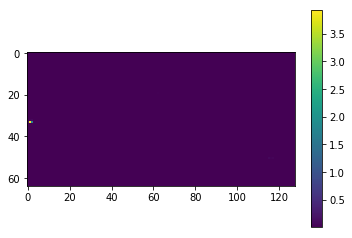

In [101]:
plt.imshow(np.max(BDT[3], axis=(0)))
plt.colorbar()

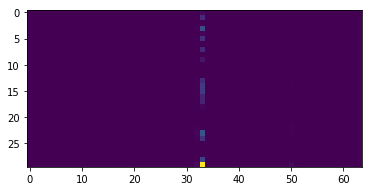

In [102]:
plt.imshow(np.max(BDT[3], axis=-1))

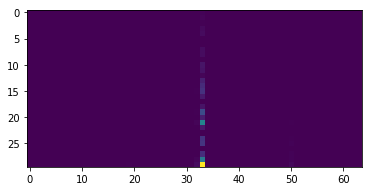

In [103]:
plt.imshow(np.max(BDQ[3], axis=-1))

In [104]:
np.argmax(np.max(BDT[-1], axis=(0,2)))

33

In [105]:
np.argmax(np.max(BDT[-1], axis=(0,1)))

1

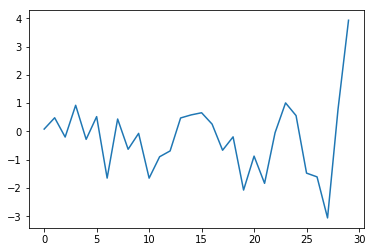

In [106]:
plt.plot(BDT[-1, :, 33, 1])

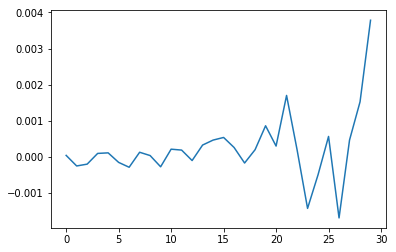

In [107]:
plt.plot(BDQ[-1, :, 33, 1])

In [109]:
inps_t3_norm = get_cb_inps(3); inps_t3_norm.shape

(152, 64, 128)

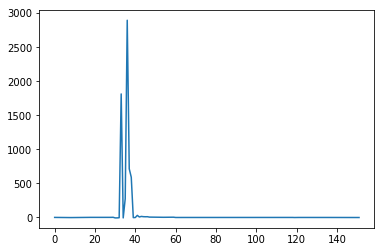

In [110]:
plt.plot(inps_t3_norm[:, 33, 1])

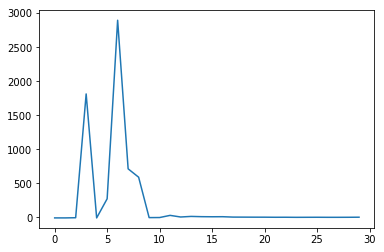

In [119]:
plt.plot(inps_t3_norm[30:60, 33, 1])

In [111]:
inps

['TC', 'QC', 'VC', 'dTdt_adiab', 'dQdt_adiab', 'PS', 'SOLIN']

In [112]:
inps_t3_raw = get_cb_inps(3, False)

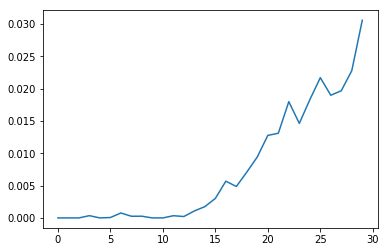

In [118]:
plt.plot(inps_t3_raw[30:60, 33, 1])

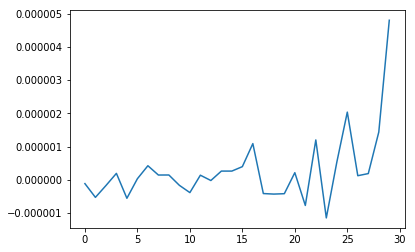

In [121]:
plt.plot(ds['BRAINDQ'][2, :, 33, 1])

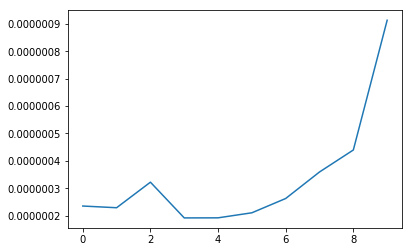

In [125]:
plt.plot(std[30:40])

## Check if variables are same...

In [70]:
TC.shape

(30, 64, 128)

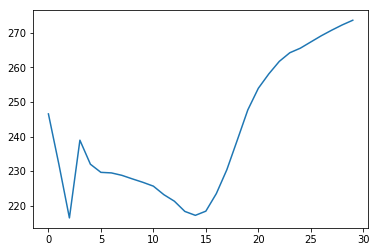

In [71]:
plt.plot(TC[:, 0, 0])

In [89]:
np.allclose(TC, ds['NNTC'][t])

True

In [90]:
np.allclose(QC, ds['NNQC'][t])

True

In [91]:
np.allclose(VC, ds['NNVC'][t])

True

In [283]:
np.allclose(dTdt_adiab, ds['dTdtadia'][t])

False

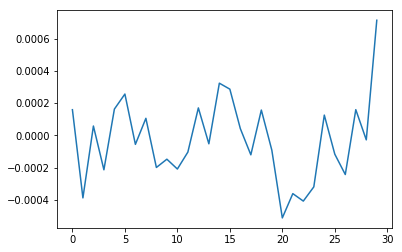

In [285]:
plt.plot(dTdt_adiab[:, 33, 0])

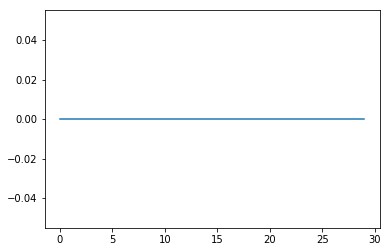

In [286]:
plt.plot(ds['dTdtadia'][t, :, 33, 0])

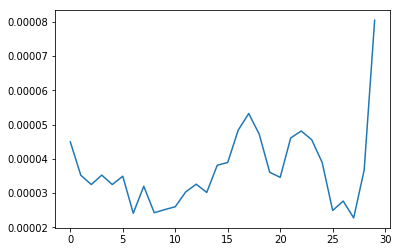

In [254]:
plt.plot(dTdt_adiab[:, 0, 0]-ds['dTdtadia'][t, :, 0, 0])

In [97]:
diff = (dTdt_adiab-ds['dTdtadia'][t])

In [102]:
diff.min(), diff.max(), dTdt_adiab.std()

(-3.1024683e-08, 3.2319804e-08, 5.7916106e-05)

In [288]:
np.allclose(dQdt_adiab, ds['dQdtadia'][t])

False

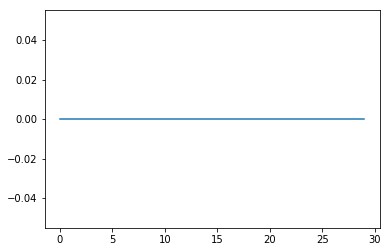

In [290]:
plt.plot(ds['dQdtadia'][t, :, 33, 0])

In [105]:
np.allclose(SOLIN, ds['NNSOLIN'][t])

False

In [108]:
SOLIN.shape

(1, 64, 128)

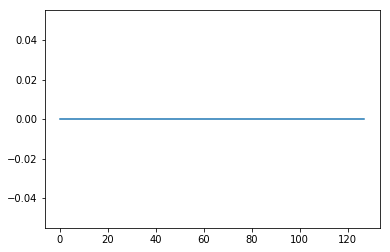

In [128]:
plt.plot(SOLIN[0, 30, :])

In [130]:
SOLIN.mean(), ds['SOLIN'][:].mean()

(0.0, 0.0)

In [112]:
ds['NNSOLIN'][t].mean()

326.2541

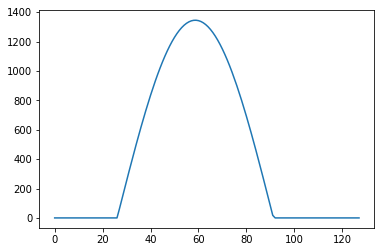

In [114]:
plt.plot(ds['NNSOLIN'][t, 30, :])

In [107]:
np.allclose(PS, ds['NNPS'][t])

False

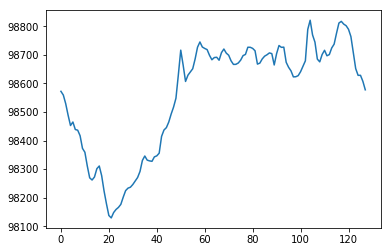

In [131]:
plt.plot(PS[0, 30, :])

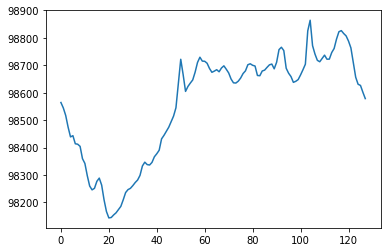

In [133]:
plt.plot(ds['NNPS'][t, 30, :])

In [136]:
diff = PS[0] - ds['NNPS'][t-1]

In [137]:
diff.mean(), diff.min(), diff.max(), PS[0].std()

(0.0, 0.0, 0.0, 1851.0485)

In [138]:
np.allclose(ds['PS'][:], ds['NNPS'][:])

True